In [2]:
#@title Integration of a process model and simple reservoir model
#@markdown This is a demo of how reservoir simulation can be intergrated into process simulation.
#@markdown <br><br>This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
#%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *

from neqsim.process import openprocess
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('classic')
%matplotlib inline

     |████████████████████████████████| 55.9 MB 1.1 MB/s 
     |████████████████████████████████| 448 kB 73.8 MB/s 


#Setting up a reservoir model
We start by establishing a simple reservoir model with gas injector and water injection

In [3]:
from neqsim.process.processTools import simplereservoir,clearProcess,runProcess, getProcess

fluid1 = fluid('srk')
fluid1.addComponent("nitrogen", 0.100)
fluid1.addComponent("CO2", 0.100)
fluid1.addComponent("methane", 30.00)
fluid1.addComponent("ethane", 1.0)
fluid1.addComponent("propane", 1.0)
fluid1.addComponent("i-butane", 01.0)
fluid1.addComponent("n-butane", 0.0)
fluid1.addComponent("n-hexane", 0.1)
fluid1.addComponent("n-heptane", 0.1)
fluid1.addComponent("n-nonane", 1.0)
fluid1.addComponent("nC10", 1.0)
fluid1.addComponent("nC12", 3.0)
fluid1.addComponent("nC15", 3.0)
fluid1.addComponent("nC20", 1.0)
fluid1.addComponent("water", 11.0)
fluid1.setMixingRule(2)
fluid1.setMultiPhaseCheck(True)

fluid1.setPressure(100.0, 'bara')
fluid1.setTemperature(100.0, 'C')

TPflash(fluid1)

clearProcess()
reservoirOps = simplereservoir(fluid1, "Well 1 reservoir", gasvolume=5.0 * 1e7, oilvolume=552.0 * 1e6, watervolume=10.0e6)

#producedGasStream = reservoirOps.addGasProducer("SLP_A32562G")
#producedGasStream.setFlowRate(0.01, "MSm3/day")

#injectionGasStream = reservoirOps.addGasInjector("SLP_A32562GI")
#fluidComposition(injectionGasStream.getFluid(), [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0])
#njectionGasStream.setFlowRate(1.1, "MSm3/day")

injectionWaterStream = reservoirOps.addWaterInjector("SLP_A32562W")
injectionWaterStream.setFlowRate(10000000.1, "kg/day")

producedOilStream = reservoirOps.addOilProducer("SLP_A32562O")
producedOilStream.setFlowRate(50000000.0, "kg/day")
runProcess()
getProcess().save('reservoir.neqsim')

# Establish the oil and gas process
A simple oil and gas process is established

In [4]:
from neqsim.process.processTools import valve,stream,simplereservoir,clearProcess,runProcess, getProcess,separator3phase,heater,separator,compressor,setpoint,recycle,mixer,pump

fluid3 = fluid1.clone()

clearProcess()
wellStream = stream(fluid3)
wellStream.setName("well stream")
wellStream.setFlowRate(10.63, "MSm3/day")
wellStream.setTemperature(40.0, "C")
wellStream.setPressure(120.0, "bara")

wellheater = heater(wellStream)
wellheater.setName("well stream cooler/heater")
wellheater.setOutPressure(62.21)
wellheater.setOutTemperature(273.15+35.21);

wellvalve = valve(wellheater.getOutStream())
wellvalve.setName("inlet choke valve")
wellvalve.setOutletPressure(52.21);

inletSeparator = separator3phase(wellvalve.getOutStream())
inletSeparator.setName("1st stage separator")

oilToInletSep = stream(fluid1.clone())
oilToInletSep.setFlowRate(1e-10, "kg/hr")
inletSeparator.addStream(oilToInletSep)

valve2 = valve(inletSeparator.getOilOutStream())
valve2.setName("oil HP to MP valve");
valve2.setOutletPressure(15.0);

cooler1 = heater(valve2.getOutStream())
cooler1.setName("oil cooler/heater to 2nd stage")
cooler1.setOutTemperature(323.15)

waterDPvalve =  valve(inletSeparator.getWaterOutStream())
waterDPvalve.setName("Water HP to LP valve")
waterDPvalve.setOutletPressure(1.01325)

waterStabSep = separator(waterDPvalve.getOutStream())
waterStabSep.setName('water degasing separator"')

waterToTreatment = stream(waterStabSep.getLiquidOutStream())
waterToTreatment.setName("water to treatment")
		
mpseparator = separator3phase(cooler1.getOutStream())
mpseparator.setName("2nd stage separator")

oilToSep = stream(fluid1.clone())
oilToSep.setFlowRate(1e-10, "kg/hr")
mpseparator.addStream(oilToSep)

valvempValve = valve(mpseparator.getOilOutStream())
valvempValve.setName("oil MP to LP valve")
valvempValve.setOutletPressure(2.8)

lpseparator = separator3phase(valvempValve.getOutStream())
lpseparator.setName("3rd stage separator")

stableOilStream  = stream(lpseparator.getOilOutStream())
stableOilStream.setName("stable oil")
		
lpcompressor = compressor(lpseparator.getGasOutStream())
lpcompressor.setName("1st stage recompressor");
compressorPresSet2 =  setpoint("comp pres LP set", lpcompressor, "pressure",valve2.getOutStream());

lpgasheater = heater(lpcompressor.getOutStream())
lpgasheater.setName('1st stage gas heat exchanger')
lpgasheater.setOutTemperature(298.15)

lpscrubber = separator(lpgasheater.getOutStream())
lpscrubber.setName("2nd stage scrubber")
liqFromlpscrubber = lpscrubber.getLiquidOutStream()

lpscrubberResyc = recycle(liqFromlpscrubber)
lpscrubberResyc.setName("mpscrubberRes")
lpscrubberResyc.setOutletStream(oilToSep)

mixermp = mixer("mp gas mixer")
mixermp.addStream(lpscrubber.getGasOutStream())
mixermp.addStream(mpseparator.getGasOutStream())

compressor2stage = compressor(mixermp.getOutStream())
compressor2stage.setName("2nd stage recompressor")

compressorPresSet = setpoint("comp pres set", compressor2stage, "pressure",inletSeparator)
		
secondndstagecooler = heater(compressor2stage.getOutStream())
secondndstagecooler.setName("2nd stage cooler")
secondndstagecooler.setOutTemperature(298.0)

scrubbberfrom2ndstage = separator(secondndstagecooler.getOutStream())
scrubbberfrom2ndstage.setName("scrubber of mix gas HP")

mixer = mixer("HP rich gas mixer")
mixer.addStream(inletSeparator.getGasOutStream())
mixer.addStream(scrubbberfrom2ndstage.getGasOutStream())

dewPointScrubberCooler = heater(mixer.getOutStream())
dewPointScrubberCooler.setName("dew point scrubber cooler2")
dewPointScrubberCooler.setOutTemperature(273.15+32.3)

mpscrubber = separator(dewPointScrubberCooler.getOutStream())
mpscrubber.setName("dew point control scrubber")

liqFrommpscrubber = mpscrubber.getLiquidOutStream()

mpscrubberResyc = recycle(liqFrommpscrubber)
mpscrubberResyc.setName("hpscrubberRes")
mpscrubberResyc.addStream(scrubbberfrom2ndstage.getLiquidOutStream())
mpscrubberResyc.setOutletStream(oilToInletSep)

exportCompressor1 = compressor(mpscrubber.getGasOutStream())
exportCompressor1.setName("export compressor 1")
exportCompressor1.setOutletPressure(85.0)

exportCooler1 = heater(exportCompressor1.getOutStream())
exportCooler1.setName('export cooler')
exportCooler1.setOutTemperature(30.0, 'C')

exportCompressor2 = compressor(exportCooler1.getOutStream())
exportCompressor2.setName("export compressor 2")
exportCompressor2.setOutletPressure(150.0)

exportCooler2 = heater(exportCompressor2.getOutStream())
exportCooler2.setName('export cooler')
exportCooler2.setOutTemperature(30.0, 'C')

richGas = stream(exportCooler2.getOutStream())
richGas.setName("rich gas")

#waterinjectionComposition = [0]*15
#waterinjectionComposition[14]= 1.0
#waterfluid = fluid1.clone()
#waterfluid.setMolarComposition(waterinjectionComposition)

#waterInjectionStream = stream(waterfluid)
waterInjectionStream = injectionWaterStream.clone()
waterInjectionStream.setName('injectionwater')
waterInjectionStream.setPressure(1.0, 'bara')
waterInjectionStream.setTemperature(10.0, 'C')
waterpump = pump(waterInjectionStream, 5.0)
waterpump.setOutletPressure(5.0)
waterpump.setName('injection water pump')
waterForInjectionStream = stream(waterpump.getOutStream())
waterForInjectionStream.setName('injected water')

getProcess().getUnit("well stream").setStream(wellStream)
getProcess().getUnit("well stream cooler/heater").setOutTemperature(66.0, "C")
getProcess().getUnit("well stream cooler/heater").setOutPressure(52.21, "bara")
getProcess().getUnit("inlet choke valve").setOutletPressure(51.21, "bara")
getProcess().getUnit("oil HP to MP valve").setOutletPressure(15.0, "bara")
getProcess().getUnit("oil cooler/heater to 2nd stage").setOutTemperature(85.0, "C")
getProcess().getUnit("oil MP to LP valve").setOutletPressure(1.8, "bara")
getProcess().getUnit("Water HP to LP valve").setOutletPressure(1.01325, "bara")
getProcess().getUnit("dew point scrubber cooler2").setOutTemperature(33.0, "C")
getProcess().getUnit("2nd stage cooler").setOutTemperature(33.0, "C")
getProcess().getUnit("1st stage gas heat exchanger").setOutTemperature(33.0, "C")
getProcess().getUnit("1st stage recompressor").setIsentropicEfficiency(0.75)
getProcess().getUnit("2nd stage recompressor").setIsentropicEfficiency(0.75)
getProcess().getUnit("export compressor 1").setIsentropicEfficiency(0.75)
getProcess().getUnit("export compressor 2").setIsentropicEfficiency(0.75)
getProcess().run()

getProcess().save('gasprocess.neqsim')

# Running the combined reservoir and process model for the lifetime of the field
Importing reservoir simulation ad process simulation and running simlation



sim year  0.0
sim year  1.0
sim year  2.0
sim year  3.0
sim year  4.0


Text(0, 0.5, 'Rich Gas FLow [MSm3/day]')

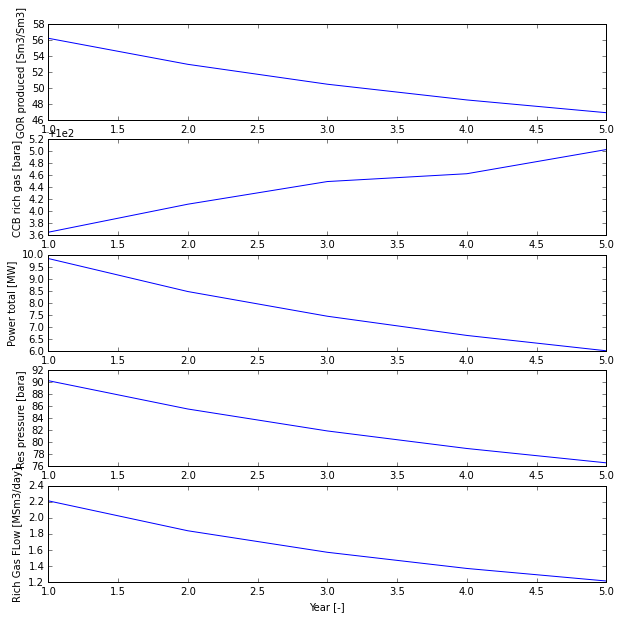

In [32]:
from neqsim.process import getProcess, openprocess
import matplotlib.pyplot as plt
resmodel = openprocess('reservoir.neqsim')
GasOilProcess = openprocess('gasprocess.neqsim')
reservoir = resmodel.getUnit('Well 1 reservoir')
wellStream = reservoir.getOilProducer(0).getStream()
initPressure = resmodel.getUnit('Well 1 reservoir').getReservoirFluid().getPressure('bara')
initFLowRate = 80000000.0
deltat = 24*60*60.0*365
resmodel.setTimeStep(deltat)

time = []
pressure = []
pressureout = []
GORprocess = []
cricondenbarrichgas = []
power = []
richGasFLowMSm3day = []

for step in range(5):
    print('sim year ' , reservoir.getTime()/(60.0*60*24*365))
    resmodel.runTransient()
    wellStream.setFlowRate(initFLowRate*(resmodel.getUnit('Well 1 reservoir').getReservoirFluid().getPressure('bara')- GasOilProcess.getUnit("inlet choke valve").getOutStream().getPressure('bara'))/initPressure, "kg/day")
    GasOilProcess.getUnit("well stream").setStream(wellStream)
    #resmodel.getWaterInjector(0).setStream(GasOilProcess.getUnit('injected water'))
    #resmodel.runTransient()
    GasOilProcess.run()
    time.append(reservoir.getTime()/(60.0*60*24*365))
    inlet_pressure = GasOilProcess.getUnit("inlet choke valve").getOutStream().getPressure('bara')
    GOR=GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
    GORprocess.append(GOR)
    cricondenbarrichgas.append(GasOilProcess.getUnit("rich gas").CCB("bara"))
    power.append(GasOilProcess.getPower("W")/1.0e6)
    pressure.append(resmodel.getUnit('Well 1 reservoir').getReservoirFluid().getPressure('bara'))
    richGasFLowMSm3day.append(GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("MSm3/day"))
    pressureout.append(GasOilProcess.getUnit("rich gas").getPressure('bara'))


plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
plt.subplot(5, 1, 1)
plt.plot(time, GORprocess)
plt.xlabel('Year [-]')
plt.ylabel('GOR produced [Sm3/Sm3]')
plt.subplot(5, 1, 2)
plt.plot(time, cricondenbarrichgas)
plt.xlabel('Year [-]')
plt.ylabel('CCB rich gas [bara]')
plt.subplot(5, 1, 3)
plt.plot(time, power)
plt.xlabel('Year [-]')
plt.ylabel('Power total [MW]')
plt.subplot(5, 1, 4)
plt.plot(time, pressure)
plt.xlabel('Year [-]')
plt.ylabel('Res pressure [bara]')
plt.subplot(5, 1, 5)
plt.plot(time, richGasFLowMSm3day)
plt.xlabel('Year [-]')
plt.ylabel('Rich Gas FLow [MSm3/day]')


In [42]:
#Read results of last year
GasOilProcess = openprocess('gasprocess.neqsim')
GasLiqidRatio = GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
compressorPower1 = GasOilProcess.getUnit("1st stage recompressor").getPower()/1.0e3
compressorPower2 = GasOilProcess.getUnit("2nd stage recompressor").getPower()/1.0e3
injectionWaterPumpPower = GasOilProcess.getUnit("injection water pump").getPower()/1.0e3
exportCompressorPower = GasOilProcess.getUnit("export compressor 1").getPower()/1.0e3
exportCompressorPower2 = GasOilProcess.getUnit("export compressor 2").getPower()/1.0e3
cooler1Duty = GasOilProcess.getUnit("1st stage gas heat exchanger").getDuty()/1e3
cooler2Duty = GasOilProcess.getUnit("2nd stage cooler").getDuty()/1e3

wellStreamFLowMSm3day = GasOilProcess.getUnit("well stream").getFluid().getFlowRate("MSm3/day")
richGasFLowMSm3day = GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("MSm3/day")
gasInletSepFlowMSm3day = GasOilProcess.getUnit("1st stage separator").getGasOutStream().getFluid().getFlowRate("MSm3/day")
stableOilFLowm3hr = GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
waterToTreatmentRatem3hr = GasOilProcess.getUnit("water to treatment").getFluid().getFlowRate("m3/hr")
resycleFLowDewPointScrubber = GasOilProcess.getUnit("dew point control scrubber").getLiquidOutStream().getFluid().getFlowRate("kg/hr")
GOR=GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/ GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
TVPofexportoil = GasOilProcess.getUnit("stable oil").TVP(30.0, "C")
CCB_exportgas = GasOilProcess.getUnit("rich gas").CCB("bara")
CCT_exportgas = GasOilProcess.getUnit("rich gas").CCT("C")

print("rich gas flow", richGasFLowMSm3day, " MSm3/day")
print("1st stage recompressor power", compressorPower1, " kW")
print("2nd stage recompressor power", compressorPower2, " kW")
print("export compressor power 1 ", exportCompressorPower, " kW")
print("export compressor power 2 ", exportCompressorPower2, " kW")
print("injection water pump power", injectionWaterPumpPower, " kW")
print("1st stage gas cooler duty ", cooler1Duty, " kW")
print("2nd stage cooler duty ", cooler2Duty, " kW")
print("stable oil production ", stableOilFLowm3hr, " m3/hr")
print("rich gas production ", richGasFLowMSm3day, " MS3/day")
print("GOR ", GOR)
print("TVP of export oil ", TVPofexportoil)
print("cricondenbar pressure of rich gas ", CCB_exportgas, " bara")
print("cricondentherm temperature of rich gas ", CCT_exportgas, " C")

rich gas flow 10.629999892011734  MSm3/day
1st stage recompressor power 3214.5886518986777  kW
2nd stage recompressor power 4518.48750027279  kW
export compressor power 1  2984.6504814646555  kW
export compressor power 2  3116.238757224123  kW
injection water pump power 58.50778635275364  kW
1st stage gas cooler duty  -7351.159888820571  kW
2nd stage cooler duty  -8319.818245229653  kW
stable oil production  2144.954451741483  m3/hr
rich gas production  10.629999892011734  MS3/day
GOR  206.49233917650454
TVP of export oil  0.9758255089220883
cricondenbar pressure of rich gas  122.61800568211365  bara
cricondentherm temperature of rich gas  309.4237738797642  C


# Calculations using a model using compressor and pump charts
.....

We start by establising pump and compressor charts including surge conditions.

In [7]:
from neqsim.process import compressorChart,compressorSurgeCurve, compressorStoneWallCurve

MW=28.01
inlepPres=100.0
inletTemp=26.2
Zinlet=0.89
curveConditions = [MW, inlepPres, inletTemp, Zinlet]

flowFactor = 1.0

speed = [12913, 12298, 11683, 11098, 10453, 9224, 8609, 8200]
flow =[
                [2789.1285, 3174.0375, 3689.2288, 4179.4503, 4570.2768, 4954.7728, 5246.0329,
                        5661.0331],
                [2571.1753, 2943.7254, 3440.2675, 3837.4448, 4253.0898, 4668.6643, 4997.1926,
                        5387.4952],
                [2415.3793, 2763.0706, 3141.7095, 3594.7436, 4047.6467, 4494.1889, 4853.7353,
                        5138.7858],
                [2247.2043, 2799.7342, 3178.3428, 3656.1551, 4102.778, 4394.1591, 4648.3224,
                        4840.4998],
                [2072.8397, 2463.9483, 2836.4078, 3202.5266, 3599.6333, 3978.0203, 4257.0022,
                        4517.345],
                [1835.9552, 2208.455, 2618.1322, 2940.8034, 3244.7852, 3530.1279, 3753.3738,
                        3895.9746],
                [1711.3386, 1965.8848, 2356.9431, 2685.9247, 3008.5154, 3337.2855, 3591.5092],
                [1636.5807, 2002.8708, 2338.0319, 2642.1245, 2896.4894, 3113.6264, 3274.8764,
                        3411.2977]]
flow = [[j*flowFactor for j in i] for i in flow]
head = [
                [80.0375, 78.8934, 76.2142, 71.8678, 67.0062, 60.6061, 53.0499, 39.728],
                [72.2122, 71.8369, 68.9009, 65.8341, 60.7167, 54.702, 47.2749, 35.7471],
                [65.1576, 64.5253, 62.6118, 59.1619, 54.0455, 47.0059, 39.195, 31.6387],
                [58.6154, 56.9627, 54.6647, 50.4462, 44.4322, 38.4144, 32.9084, 28.8109],
                [52.3295, 51.0573, 49.5283, 46.3326, 42.3685, 37.2502, 31.4884, 25.598],
                [40.6578, 39.6416, 37.6008, 34.6603, 30.9503, 27.1116, 23.2713, 20.4546],
                [35.2705, 34.6359, 32.7228, 31.0645, 27.0985, 22.7482, 18.0113],
                [32.192, 31.1756, 29.1329, 26.833, 23.8909, 21.3324, 18.7726, 16.3403]
        ]

polyEff =  [
                [77.2452238409573, 79.4154186459363, 80.737960012489, 80.5229826589649,
                        79.2210931638144, 75.4719133864634, 69.6034181197298, 58.7322388482707],
                [77.0107837113504, 79.3069974136389, 80.8941189021135, 80.7190194665918,
                        79.5313242980328, 75.5912622896367, 69.6846136362097, 60.0043057990909],
                [77.0043065299874, 79.1690958847856, 80.8038169975675, 80.6543975614197,
                        78.8532389102705, 73.6664774270613, 66.2735600426727, 57.671664571658],
                [77.0716623789093, 80.4629750233093, 81.1390811169072, 79.6374242667478,
                        75.380928428817, 69.5332969549779, 63.7997587622339, 58.8120614497758],
                [76.9705872525642, 79.8335492585324, 80.9468133671171, 80.5806471927835,
                        78.0462158225426, 73.0403707523258, 66.5572286338589, 59.8624822515064],
                [77.5063036680357, 80.2056198362559, 81.0339108025933, 79.6085962687939,
                        76.3814534404405, 70.8027503005902, 64.6437367160571, 60.5299349982342],
                [77.8175271586685, 80.065165942218, 81.0631362122632, 79.8955051771299,
                        76.1983240929369, 69.289982774309, 60.8567149372229],
                [78.0924334304045, 80.9353551568667, 80.7904437766234, 78.8639325223295,
                        75.2170936751143, 70.3105081673411, 65.5507568533569, 61.0391468300337]
                 ]

compressorChart(exportCompressor1, curveConditions, speed, flow, head, polyEff)
exportCompressor1.getCompressorChart().setHeadUnit('meter')
exportCompressor1.getCompressorChart().setHeadUnit("kJ/kg")

surgeFlow = [2789.1285, 2571.1753, 2415.3793, 2247.2043, 2072.8397, 1835.9552, 1711.3386, 1636.5807]
surgeFlow = [j*flowFactor for j in surgeFlow]
surgeHead = [80.0375, 72.2122, 65.1576, 58.6154,52.3295,40.6578,35.2705,32.192 ]
compressorSurgeCurve(exportCompressor1, curveConditions, surgeFlow, surgeHead)

exportCompressor1.setUsePolytropicCalc(True)
exportCompressor1.getAntiSurge().setActive(True)
exportCompressor1.getAntiSurge().setSurgeControlFactor(1.0)

exportCompressor1.setSpeed(11000)
exportCompressor1.run()
inletCompFLuid = exportCompressor1.getInStream().getFluid()
extiCompFLuid = exportCompressor1.getOutStream().getFluid()
fluidHead = exportCompressor1.getPolytropicHead()
surgeFLow = exportCompressor1.getCompressorChart().getSurgeCurve().getSurgeFlow(fluidHead)
power = exportCompressor1.getPower()
fluidEff = exportCompressor1.getPolytropicEfficiency()
print('feed flow ', inletCompFLuid.getFlowRate('m3/hr'), ' surgeflow ', surgeFLow,' inletpres ', inletCompFLuid.getPressure('bara'), ' outpres ', extiCompFLuid.getPressure('bara'), ' fluidhead ', fluidHead, ' meter ',  ' fluideff ', fluidEff, ' power ', power/1e6, ' MW')
printFrame(extiCompFLuid)

feed flow  2911.718817825417  surgeflow  2169.788057562291  inletpres  51.21  outpres  83.29559326030326  fluidhead  55.63598597207837  meter   fluideff  0.8148180236067444  power  2.6040700668117  MW
                           total                 gas                       
           nitrogen   1.93313E-3          1.93313E-3        [mole fraction]
                CO2   4.30166E-3          4.30166E-3        [mole fraction]
            methane   8.46144E-1          8.46144E-1        [mole fraction]
             ethane   4.67422E-2          4.67422E-2        [mole fraction]
            propane   5.32231E-2          5.32231E-2        [mole fraction]
           i-butane   4.57226E-2          4.57226E-2        [mole fraction]
           n-butane          0E0                 0E0        [mole fraction]
           n-hexane   5.61535E-4          5.61535E-4        [mole fraction]
          n-heptane   1.67328E-4          1.67328E-4        [mole fraction]
           n-nonane   1.81743E-4       

In [8]:
from neqsim.process import compressorChart,compressorSurgeCurve, compressorStoneWallCurve

MW=28.01
inlepPres=100.0
inletTemp=26.2
Zinlet=0.89
curveConditions = [MW, inlepPres, inletTemp, Zinlet]

flowFactor = 0.7

speed = [12913, 12298, 11683, 11098, 10453, 9224, 8609, 8200]
flow =[
                [2789.1285, 3174.0375, 3689.2288, 4179.4503, 4570.2768, 4954.7728, 5246.0329,
                        5661.0331],
                [2571.1753, 2943.7254, 3440.2675, 3837.4448, 4253.0898, 4668.6643, 4997.1926,
                        5387.4952],
                [2415.3793, 2763.0706, 3141.7095, 3594.7436, 4047.6467, 4494.1889, 4853.7353,
                        5138.7858],
                [2247.2043, 2799.7342, 3178.3428, 3656.1551, 4102.778, 4394.1591, 4648.3224,
                        4840.4998],
                [2072.8397, 2463.9483, 2836.4078, 3202.5266, 3599.6333, 3978.0203, 4257.0022,
                        4517.345],
                [1835.9552, 2208.455, 2618.1322, 2940.8034, 3244.7852, 3530.1279, 3753.3738,
                        3895.9746],
                [1711.3386, 1965.8848, 2356.9431, 2685.9247, 3008.5154, 3337.2855, 3591.5092],
                [1636.5807, 2002.8708, 2338.0319, 2642.1245, 2896.4894, 3113.6264, 3274.8764,
                        3411.2977]]

flow = [[j*flowFactor for j in i] for i in flow]
head = [
                [80.0375, 78.8934, 76.2142, 71.8678, 67.0062, 60.6061, 53.0499, 39.728],
                [72.2122, 71.8369, 68.9009, 65.8341, 60.7167, 54.702, 47.2749, 35.7471],
                [65.1576, 64.5253, 62.6118, 59.1619, 54.0455, 47.0059, 39.195, 31.6387],
                [58.6154, 56.9627, 54.6647, 50.4462, 44.4322, 38.4144, 32.9084, 28.8109],
                [52.3295, 51.0573, 49.5283, 46.3326, 42.3685, 37.2502, 31.4884, 25.598],
                [40.6578, 39.6416, 37.6008, 34.6603, 30.9503, 27.1116, 23.2713, 20.4546],
                [35.2705, 34.6359, 32.7228, 31.0645, 27.0985, 22.7482, 18.0113],
                [32.192, 31.1756, 29.1329, 26.833, 23.8909, 21.3324, 18.7726, 16.3403]
        ]

polyEff =  [
                [77.2452238409573, 79.4154186459363, 80.737960012489, 80.5229826589649,
                        79.2210931638144, 75.4719133864634, 69.6034181197298, 58.7322388482707],
                [77.0107837113504, 79.3069974136389, 80.8941189021135, 80.7190194665918,
                        79.5313242980328, 75.5912622896367, 69.6846136362097, 60.0043057990909],
                [77.0043065299874, 79.1690958847856, 80.8038169975675, 80.6543975614197,
                        78.8532389102705, 73.6664774270613, 66.2735600426727, 57.671664571658],
                [77.0716623789093, 80.4629750233093, 81.1390811169072, 79.6374242667478,
                        75.380928428817, 69.5332969549779, 63.7997587622339, 58.8120614497758],
                [76.9705872525642, 79.8335492585324, 80.9468133671171, 80.5806471927835,
                        78.0462158225426, 73.0403707523258, 66.5572286338589, 59.8624822515064],
                [77.5063036680357, 80.2056198362559, 81.0339108025933, 79.6085962687939,
                        76.3814534404405, 70.8027503005902, 64.6437367160571, 60.5299349982342],
                [77.8175271586685, 80.065165942218, 81.0631362122632, 79.8955051771299,
                        76.1983240929369, 69.289982774309, 60.8567149372229],
                [78.0924334304045, 80.9353551568667, 80.7904437766234, 78.8639325223295,
                        75.2170936751143, 70.3105081673411, 65.5507568533569, 61.0391468300337]
                 ]

compressorChart(exportCompressor2, curveConditions, speed, flow, head, polyEff)
exportCompressor2.getCompressorChart().setHeadUnit('meter')
exportCompressor2.getCompressorChart().setHeadUnit("kJ/kg")

surgeFlow = [2789.1285, 2571.1753, 2415.3793, 2247.2043, 2072.8397, 1835.9552, 1711.3386, 1636.5807]
surgeFlow = [j*flowFactor for j in surgeFlow]
surgeHead = [80.0375, 72.2122, 65.1576, 58.6154,52.3295,40.6578,35.2705,32.192 ]
compressorSurgeCurve(exportCompressor2, curveConditions, surgeFlow, surgeHead)

exportCompressor2.setUsePolytropicCalc(True)
exportCompressor2.getAntiSurge().setActive(False)
exportCompressor2.getAntiSurge().setSurgeControlFactor(1.0)

exportCompressor2.setSpeed(11000)
exportCompressor2.run()
inletCompFLuid = exportCompressor2.getInStream().getFluid()
extiCompFLuid = exportCompressor2.getOutStream().getFluid()
fluidHead = exportCompressor2.getPolytropicHead()
surgeFLow = exportCompressor2.getCompressorChart().getSurgeCurve().getSurgeFlow(fluidHead)
power = exportCompressor2.getPower()
fluidEff = exportCompressor2.getPolytropicEfficiency()
print('feed flow ', inletCompFLuid.getFlowRate('m3/hr'), ' surgeflow ', surgeFLow,' inletpres ', inletCompFLuid.getPressure('bara'), ' outpres ', extiCompFLuid.getPressure('bara'), ' fluidhead ', fluidHead, ' meter ',  ' fluideff ', fluidEff, ' power ', power/1e6, ' MW')
printFrame(extiCompFLuid)

feed flow  1574.5654804282337  surgeflow  1551.797209053687  inletpres  85.0  outpres  148.66194923986208  fluidhead  57.598730884338984  meter   fluideff  0.7700213892210607  power  2.852775715983466  MW
                           total                 gas                       
           nitrogen   1.93313E-3          1.93313E-3        [mole fraction]
                CO2   4.30166E-3          4.30166E-3        [mole fraction]
            methane   8.46144E-1          8.46144E-1        [mole fraction]
             ethane   4.67422E-2          4.67422E-2        [mole fraction]
            propane   5.32231E-2          5.32231E-2        [mole fraction]
           i-butane   4.57226E-2          4.57226E-2        [mole fraction]
           n-butane          0E0                 0E0        [mole fraction]
           n-hexane   5.61535E-4          5.61535E-4        [mole fraction]
          n-heptane   1.67328E-4          1.67328E-4        [mole fraction]
           n-nonane   1.81743E-4   

# Calculation of total power consumption and CO2 emsissions

In [7]:
totalElectricalPower = getProcess().getPower('MW')
print('total electrical power ', totalElectricalPower, ' MW')

total electrical power  10.39565400533592  MW


In [8]:
gasLowerHeatingValue = 802.0*1e3 # richGas.LCV()  # J/mol - check the call to LCV in neqsim
molSm3 = 101325.0/8.314/288.15
gasLowerHeatingValue2 = gasLowerHeatingValue*molSm3/1e6 # MJ/Sm3

efficiencyOFGasTurbines = 0.3

gasForPower = totalElectricalPower/gasLowerHeatingValue2/efficiencyOFGasTurbines*3600.0*24/1e6 #MSm3/day

In [9]:
CO2emissionFactor = 2.2 # kg/Sm3

CO2emissions = gasForPower*1e6*CO2emissionFactor/1e3*265  #tons CO2/year
print('CO2 missions ', CO2emissions , ' tons CO2/year')

CO2 missions  51457.71798949  tons CO2/year


In [10]:
#Calculation of production in oil equivalents

oilEqu = getProcess().getUnit('rich gas').getFlowRate("Sm3/day")/1000.0 + getProcess().getUnit('stable oil').getFlowRate("Sm3/day")

CO2emissionPerOilEquivalent = CO2emissions*1e6/(oilEqu*365)

print('CO2 emissions per produced oil equivavalent ', round(CO2emissionPerOilEquivalent, 2), ' kg CO2/Sm3 oe')

CO2 emissions per produced oil equivavalent  27.57  kg CO2/Sm3 oe


# Running life time calculations for a field

In [9]:
runProcess()

In [9]:
getProcess().save('gasprocess.neqsim')

In [ ]:
from neqsim.process import getProcess, openprocess
import matplotlib.pyplot as plt
resmodel = openprocess('reservoir.neqsim')
GasOilProcess = openprocess('gasprocess.neqsim')
reservoir = resmodel.getUnit('Well 1 reservoir')
wellStream = reservoir.getOilProducer(0).getStream()
initPressure = resmodel.getUnit('Well 1 reservoir').getReservoirFluid().getPressure('bara')
initFLowRate = GasOilProcess.getUnit("well stream").getFlowRate("MSm3/day")
deltat = 24*60*60.0*365
resmodel.setTimeStep(deltat)

time = []
pressure = []
pressureout = []
GORprocess = []
cricondenbarrichgas = []
power = []
richGasFLowMSm3day = []

for step in range(5):
    print('sim year ' , reservoir.getTime()/(60.0*60*24*365))
    resmodel.runTransient()
    wellStream.setFlowRate(initFLowRate*(resmodel.getUnit('Well 1 reservoir').getReservoirFluid().getPressure('bara')- GasOilProcess.getUnit("inlet choke valve").getOutStream().getPressure('bara'))/initPressure, "MSm3/day")
    GasOilProcess.getUnit("well stream").setStream(wellStream)
    #resmodel.getWaterInjector(0).setStream(GasOilProcess.getUnit('injected water'))
    #resmodel.runTransient()
    GasOilProcess.run()
    time.append(reservoir.getTime()/(60.0*60*24*365))
    inlet_pressure = GasOilProcess.getUnit("inlet choke valve").getOutStream().getPressure('bara')
    GOR=GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
    GORprocess.append(GOR)
    cricondenbarrichgas.append(GasOilProcess.getUnit("rich gas").CCB("bara"))
    power.append(GasOilProcess.getPower("W")/1.0e6)
    pressure.append(resmodel.getUnit('Well 1 reservoir').getReservoirFluid().getPressure('bara'))
    richGasFLowMSm3day.append(GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("MSm3/day"))
    pressureout.append(GasOilProcess.getUnit("rich gas").getPressure('bara'))


plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
plt.subplot(5, 1, 1)
plt.plot(time, GORprocess)
plt.xlabel('Year [-]')
plt.ylabel('GOR produced [Sm3/Sm3]')
plt.subplot(5, 1, 2)
plt.plot(time, cricondenbarrichgas)
plt.xlabel('Year [-]')
plt.ylabel('CCB rich gas [bara]')
plt.subplot(5, 1, 3)
plt.plot(time, power)
plt.xlabel('Year [-]')
plt.ylabel('Power total [MW]')
plt.subplot(5, 1, 4)
plt.plot(time, pressureout)
plt.xlabel('Year [-]')
plt.ylabel('Pressure out[bara]')
plt.subplot(5, 1, 5)
plt.plot(time, richGasFLowMSm3day)
plt.xlabel('Year [-]')

sim year  0.0
